# Network Traffic Forecasting (using time series data)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **univariate forecasting** (predict only 1 series), and **multivariate forecasting** (predicts more than 1 series at the same time) using Project Chronos.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [4]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 2 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 

In [5]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps'
raw_df.AvgRate.str[-4:].unique() 

# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x:float(x[:-4]) if x.endswith("Mbps") else float(x[:-4])*1000)

df["total"] = raw_df["total"]

In [6]:
df.head()

,StartTime,AvgRate,total
0,2018-01-01 00:00:00,306.23,275605455598
1,2018-01-01 02:00:00,285.03,256527692256
2,2018-01-01 04:00:00,247.39,222652190823
3,2018-01-01 06:00:00,211.55,190396029658
4,2018-01-01 08:00:00,234.82,211340468977


Plot the data to see how the KPI's look like

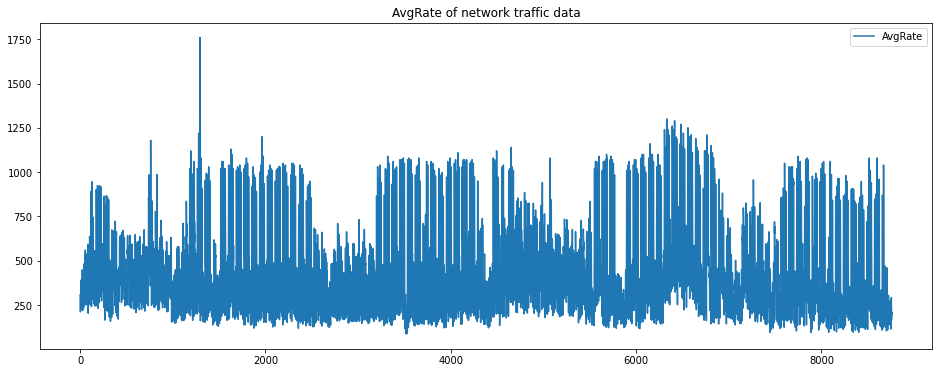

In [7]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

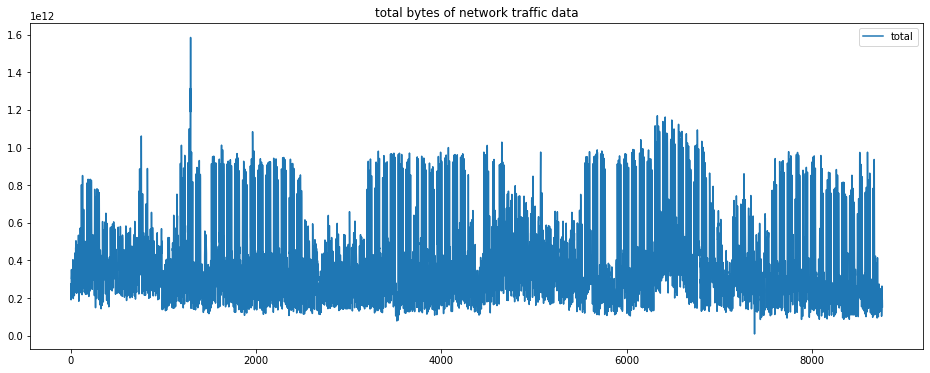

In [8]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering & Data Preperation

For feature engineering, we use year, month, week, day of week and hour as features in addition to the target KPI values.

For data preperation, we impute the data to handle missing data and scale the data.

We generate a built-in TSDataset to complete the whole processing.

In [3]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

# we look back one week data which is of the frequency of 2h.
look_back = 84
# specify the number of steps to be predicted，one day is selected by default.
horizon = 1

In [10]:
tsdata_train, _, tsdata_test = TSDataset.from_pandas(df, dt_col="StartTime", target_col=["AvgRate","total"], with_split=True, test_ratio=0.1)
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

# Time series forecasting 

### Univariate forecasting

For _univariate_ forecasting, we forecast ``AvgRate`` only. We need to roll the data on corresponding target column with tsdataset. 

In [11]:
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.roll(lookback=look_back, horizon=horizon, target_col="AvgRate")

x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape    

((7800, 84, 7), (7800, 1, 1), (792, 84, 7), (792, 1, 1))

For univariate forcasting, we use LSTMForecaster for forecasting.

In [12]:
from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster

First we initiate a LSTMForecaster. 
* `feature_dim` should match the training data input feature, so we just use the last dimension of train data shape. 
* `target_dim` equals the variate num we want to predict. We set target_dim=1 for univariate forecasting.

In [13]:
# build model
forecaster = LSTMForecaster(past_seq_len=x_train.shape[1],
                            input_feature_num=x_train.shape[-1],
                            output_feature_num=y_train.shape[-1],
                            hidden_dim=16,
                            layer_num=2,
                            lr=0.001)

Then we use fit to train the model. Wait sometime for it to finish.

In [14]:
%%time
forecaster.fit(data=(x_train, y_train), batch_size=1024, epochs=50)

Loss: 0.10204107314348221: 100%|██████████| 8/8 [00:01<00:00,  7.33it/s]


CPU times: user 9min 5s, sys: 1.88 s, total: 9min 7s
Wall time: 55.1 s


{'mse': 0.08079124385043249}

After training is finished. You can use the forecaster to do prediction and evaluation.

In [15]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [16]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

calculate the symetric mean absolute percentage error.

In [17]:
from bigdl.orca.automl.metrics import Evaluator
# evaluate with sMAPE
print("sMAPE is", Evaluator.evaluate("smape", y_test_unscale, y_pred_unscale))
# evaluate with mean_squared_error
print("mean_squared error is", Evaluator.evaluate("mse", y_test_unscale, y_pred_unscale))

sMAPE is [[8.38150542]]
mean_squared error is [[4664.04810569]]


### multivariate forecasting 

For _multivariate_ forecasting, we forecast `AvgRate` and `total` at the same time. We need to roll the data on corresponding target column with tsdataset. 

In [4]:
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.roll(lookback=look_back, horizon=horizon, target_col=["AvgRate","total"])
    
x_train_m, y_train_m = tsdata_train.to_numpy()
x_test_m, y_test_m = tsdata_test.to_numpy()
y_train_m, y_test_m = y_train_m[:, 0, :], y_test_m[:, 0, :]
x_train_m.shape, y_train_m.shape, x_test_m.shape, y_test_m.shape

((7800, 84, 2), (7800, 2), (792, 84, 2), (792, 2))

For multivariate forecasting, we use MTNetForecaster for forecasting. 

In [5]:
from bigdl.chronos.forecaster.tf.mtnet_forecaster import MTNetForecaster

2022-04-01 03:44:09.844660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 03:44:09.844692: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/liangs/BigDL/python/chronos/src/bigdl/chronos/forecaster/__init__.py:36: UserWarning: Please install `tensorflow<2.0.0` to use MTNetForecaster.
  warnings.warn("Please install `tensorflow<2.0.0` to use MTNetForecaster.")
Importing plotly failed. Interactive plots will not work.


First, we initialize a mtnet_forecaster according to input data shape. The lookback length is equal to `(long_series_num+1)*series_length` Details refer to [chronos docs](https://github.com/intel-analytics/bigdl/tree/branch-2.0/python/chronos/src/bigdl/chronos).

In [6]:
mtnet_forecaster = MTNetForecaster(target_dim=y_train_m.shape[-1],
                                   feature_dim=x_train_m.shape[-1],
                                   long_series_num=6,
                                   series_length=12,
                                   ar_window_size=6,
                                   cnn_height=4)

Now we train the model and wait till it finished. 

In [7]:
%%time
hist = mtnet_forecaster.fit(data=(x_train_m, y_train_m), batch_size=1024, epochs=20)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-04-01 03:44:15.121112: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-01 03:44:15.121162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rose-X299-AORUS-Gaming-3-Pro): /proc/driver/nvidia/version does not exist
2022-04-01 03:44:15.121807: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Build model took 3.063882350921631s
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/liangs/miniconda3/envs/chronos-lite/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 51s 543ms/step - loss: 0.8379 - mean_squared_error: 1.1065
Epoch 2/20
8/8 [==============================] - 4s 552ms/step - loss: 0.7749 - mean_squared_error: 1.0249
Epoch 3/20
8/8 [==============================] - 4s 549ms/step - loss: 0.7363 - mean_squared_error: 1.0185
Epoch 4/20
8/8 [==============================] - 5s 564ms/step - loss: 0.7021 - mean_squared_error: 0.9352
Epoch 5/20
8/8 [==============================] - 4s 560ms/step - loss: 0.6674 - mean_squared_error: 0.8591
Epoch 6/20
8/8 [==============================] - 4s 546ms/step - loss: 0.6260 - mean_squared_error: 0.8100
Epoch 7/20
8/8 [==============================] - 4s 557ms/step - loss: 0.5829 - mean_squared_error: 0.7103
Epoch 8/20
8/8 [==============================] - 5s 570ms/step - loss: 0.5359 - mean_squared_error: 0.6185
Epoch 9/20
8/8 [==============================] - 5s 576ms/step - loss: 0.4851 - mean_squared_error: 0.5173
Epoch 10/20
8/8 [=====================

Use the model for prediction and inverse the scaling of the prediction results

In [8]:
y_pred_m = mtnet_forecaster.predict(x_test_m)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
y_pred_m_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_pred_m, axis=1))[:, 0, :]
y_test_m_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_test_m, axis=1))[:, 0, :]

In [13]:
from bigdl.chronos.metric.forecast_metrics import Evaluator

res = Evaluator.evaluate(["smape", "mse"],
                         y_true=y_test_m_unscale,
                         y_pred=y_pred_m_unscale)

# evaluate with sMAPE
print("sMAPE is", res[0])
# evaluate with mean_squared_error
print("mean_squared error is", res[1])

sMAPE is [0.20047474 0.21366327]
mean_squared error is [1.0533649e+04 9.7030268e+21]


plot actual and prediction values for `AvgRate` KPI

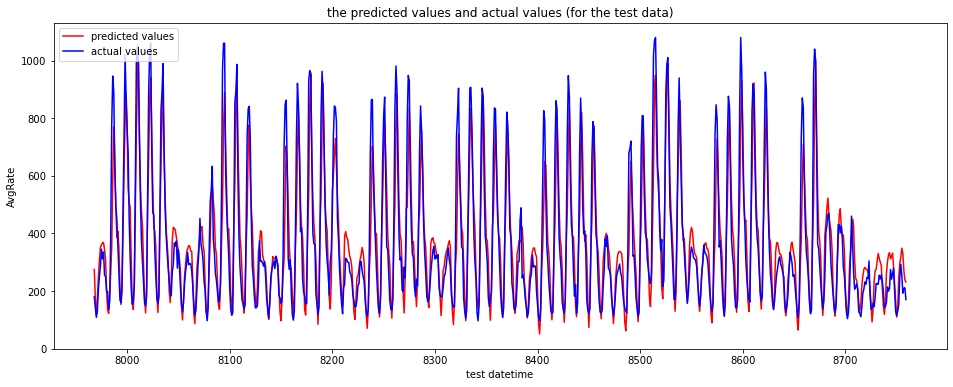

In [15]:
multi_target_value = ["AvgRate","total"]
test_date=df[-y_test_m_unscale.shape[0]:].index
plot_predict_actual_values(test_date, y_pred_m_unscale[:,0], y_test_m_unscale[:,0], ylabel=multi_target_value[0])

plot actual and prediction values for `total bytes` KPI

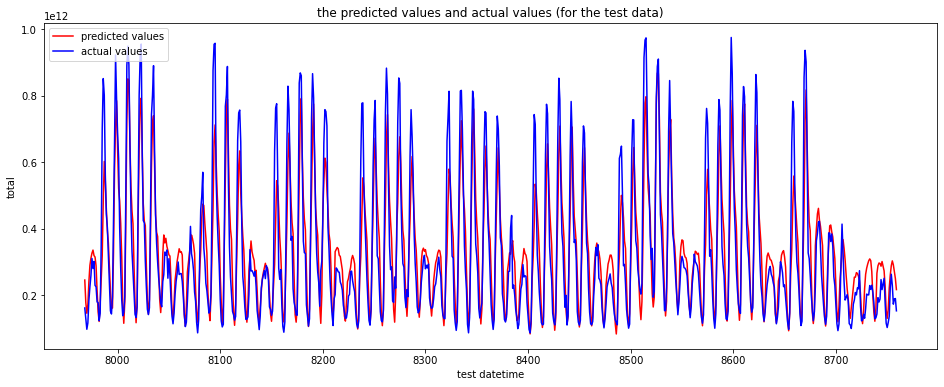

In [16]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,1], y_test_m_unscale[:,1], ylabel=multi_target_value[1])